### 할당된 GPU 확인

In [ ]:
!nvidia-smi

Tue Jun 15 05:21:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [ ]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [ ]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 109kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 3.8MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595697 sha256=d892755ac26e4085eec79040175f251b486870705fc9990ac527474a89904bbf
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 4.0MB/s 
     |████████████████████████████████| 2.3MB 3.9MB/s 
     |████████████████████████████████| 901kB 22.7MB/s 
     |████████████████████████████████| 3.3MB 24.6MB/s 


In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-lo2rucud
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-lo2rucud
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12718 sha256=a89590ab1ce2e6c4ee298ef5a17f6729755823ccc15699e80810517e8e38959f
  Stored in directory: /tmp/pip-ephem-wheel-cache-l11eysdx/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [ ]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [ ]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/problem_ner_min_re_275_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber.csv'

In [ ]:
df = pd.read_csv(file1)

In [ ]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'id', 'title', 'description', 'input', 'output', 'text', 'ner_decode',
       'list_ner', 'ner_preprocessed_desc', 'Mathematics',
       'Dynamic_programming', 'Implementation', 'Graph_theory',
       'Data_structures', 'Greedy', 'String', 'Graph_traversal',
       'Bruteforcing', 'Tree', 'Binary_search', 'Number_theory',
       'Breadth_first_search', 'Depth_first_search', 'Dijkstras',
       'Divide_and_conquer', 'Stack', 'Priority_queue', 'only_korean_desc',
       'only_korean_input', 'only_korean_output', 'only_korean_variable_desc',
       'only_korean_variablenumber_desc', 'only_korean_variablenumber_input',
       'only_korean_variablenumber_output', 'variablenumber_desc',
       'variablenumber_input', 'variablenumber_output',
       'desc_variabel_renumber', 'input_variabel_renumber',
       'output_variabel_renumber', 'desc_variabel_renumber_0',
       'input_variabel_renumber_0', 'output_varia

In [ ]:
target_name = ['Mathematics', 'Dynamic_programming', 'Implementation', 'Graph_theory',
       'Data_structures', 'Greedy', 'String', 'Graph_traversal',
       'Bruteforcing', 'Tree', 'Binary_search', 'Number_theory',
       'Breadth_first_search', 'Depth_first_search', 'Dijkstras',
       'Divide_and_conquer', 'Stack', 'Priority_queue']

In [ ]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5)

In [ ]:
def set_data(df) :
  dataset = []
  for index, row in df.iterrows():
    problem = []
    desc = row['desc_variabel_renumber_0']
    if not pd.isna(row['input_variabel_renumber_0']) :
       desc = desc + row['input_variabel_renumber_0'] 
    problem.append(desc)
    for i in target_name :
      problem.append(row[i])
    dataset.append(problem)
  return dataset

In [ ]:
dataset_train = set_data(train_df)
dataset_valid = set_data(valid_df)
dataset_test = set_data(test_df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [ ]:
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)
#tokenizer = get_tokenizer()

### 데이터셋 관련 코드

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = np.array([i[label_idx:] for i in dataset], dtype=np.int32)

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [ ]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
num_epochs = 8
max_grad_norm = 1
log_interval = 100
learning_rate =  1e-5

### 데이터 셋 표준화 과정

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
        self.classifier = nn.Linear(8096, num_classes)
        #16, 8096
        #32, 16192
        self.kernel_num = 16
        self.conv1d_maxpooling1 = nn.Sequential(
            nn.Conv1d(hidden_size, self.kernel_num, 4, stride = 2),
            nn.ReLU(),
            nn.MaxPool1d(2, 1),
            nn.Dropout(dr_rate)
        )
        self.conv1d_maxpooling2 = nn.Sequential(
            nn.Conv1d(hidden_size, self.kernel_num,8, stride = 2),
            nn.ReLU(),
            nn.MaxPool1d(2, 1),
            nn.Dropout(dr_rate)
        )

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        op, _ = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        out1 = self.conv1d_maxpooling1(op.transpose(1, 2))
        out2 = self.conv1d_maxpooling2(op.transpose(1, 2))
        out = torch.cat((out1, out2), 2)
        out = out.reshape(out.size(0), -1)
        
        return  self.classifier(out)

### model 할당

In [ ]:
model = BERTClassifier(bertmodel, num_classes=18, dr_rate=0.1).to(device) 

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

### optimizer와 loss function 설정

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.MultiLabelSoftMarginLoss()

### 잘 모르겠음 ;;

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

### 정확도 계산하는 함수

In [ ]:
threshold = 0.5

In [ ]:
def calc_accuracy_multilabel(X,Y):
    N, C = Y.shape
    X[X >= threshold] = 1
    X[X < threshold] = 0
    train_acc = (X == Y).sum().data.cpu().numpy()/ (N * C)
    return train_acc

# train 시키는 코드

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
train_loss_values = []
validation_loss_values = [] 
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.float().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy_multilabel(torch.sigmoid(out), label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        out = torch.sigmoid(out)

        validation_loss += loss.item() 
        test_acc += calc_accuracy_multilabel(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


epoch 1 batch id 1 loss 0.6865713000297546 train acc 0.5694444444444444
epoch 1 batch id 101 loss 0.4542503356933594 train acc 0.7850660066006604
epoch 1 batch id 201 loss 0.3139481544494629 train acc 0.8449419568822557
epoch 1 batch id 301 loss 0.26155394315719604 train acc 0.8646179401993361

epoch 1 train acc 0.8718010018214938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.9066162681669013


epoch 2 batch id 1 loss 0.22614379227161407 train acc 0.9236111111111112
epoch 2 batch id 101 loss 0.30658355355262756 train acc 0.9069719471947196
epoch 2 batch id 201 loss 0.2905440628528595 train acc 0.9060945273631844
epoch 2 batch id 301 loss 0.249553844332695 train acc 0.9059846806939833

epoch 2 train acc 0.905991955069824



epoch 2 test acc 0.9065576652601971


epoch 3 batch id 1 loss 0.22620539367198944 train acc 0.9305555555555556
epoch 3 batch id 101 loss 0.3344423770904541 train acc 0.9080033003300333
epoch 3 batch id 201 loss 0.263166606426239 train acc 0.9067855168601443
epoch 3 batch id 301 loss 0.24208083748817444 train acc 0.906423034330011

epoch 3 train acc 0.9063790224650876



epoch 3 test acc 0.9097808251289267


epoch 4 batch id 1 loss 0.21980071067810059 train acc 0.9305555555555556
epoch 4 batch id 101 loss 0.306404709815979 train acc 0.9110973597359738
epoch 4 batch id 201 loss 0.26039987802505493 train acc 0.9106896075179656
epoch 4 batch id 301 loss 0.2401476502418518 train acc 0.9099990771502398

epoch 4 train acc 0.9098626290224655



epoch 4 test acc 0.9115389123300519


epoch 5 batch id 1 loss 0.21760809421539307 train acc 0.9236111111111112
epoch 5 batch id 101 loss 0.2992957830429077 train acc 0.9135726072607262
epoch 5 batch id 201 loss 0.25631028413772583 train acc 0.912762576008844
epoch 5 batch id 301 loss 0.23175345361232758 train acc 0.9127214839424131

epoch 5 train acc 0.9124962052216141



epoch 5 test acc 0.9129160806375998


epoch 6 batch id 1 loss 0.21712461113929749 train acc 0.9305555555555556
epoch 6 batch id 101 loss 0.2778650224208832 train acc 0.9163228822882287
epoch 6 batch id 201 loss 0.23001398146152496 train acc 0.9170812603648424
epoch 6 batch id 301 loss 0.21459537744522095 train acc 0.9171511627906973

epoch 6 train acc 0.9168791742562226



epoch 6 test acc 0.9152601969057665


epoch 7 batch id 1 loss 0.22809866070747375 train acc 0.9097222222222222
epoch 7 batch id 101 loss 0.2640190124511719 train acc 0.9196919691969198
epoch 7 batch id 201 loss 0.20455417037010193 train acc 0.9207435046987288
epoch 7 batch id 301 loss 0.21254754066467285 train acc 0.9200581395348834

epoch 7 train acc 0.9198580752884019



epoch 7 test acc 0.9156704172526959


epoch 8 batch id 1 loss 0.19642126560211182 train acc 0.9236111111111112
epoch 8 batch id 101 loss 0.26278451085090637 train acc 0.9227172717271727
epoch 8 batch id 201 loss 0.2053404003381729 train acc 0.9231965174129351
epoch 8 batch id 301 loss 0.20705102384090424 train acc 0.9218576965669982

epoch 8 train acc 0.9214215239829986



epoch 8 test acc 0.9143518518518522


### loss graph 그린다

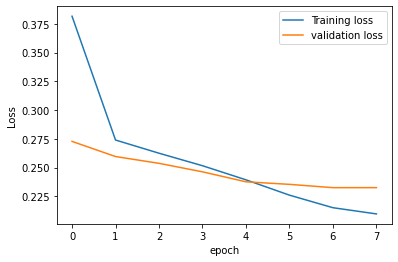

In [ ]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### predict하는 코드

In [ ]:
pred_list = []
test_label = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    test_label.extend(label)
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    out = torch.sigmoid(out)
    pred_list.extend(out.cpu().numpy())

pred_list = np.array([a.tolist() for a in pred_list])
test_label = np.array([a.squeeze().tolist() for a in test_label])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


##성능분석

In [ ]:
thresholds = [0.4, 0.34, 0.3, 0.35,
              0.25, 0.16, 0.28, 0.27,
              0.14, 0.18, 0.14, 0.28,
              0.19, 0.13, 0.2,
              0.1, 0.05, 0.06]

In [ ]:
acc = 0.0
for i in range(len(pred_list)) :
  sum = 0.0
  all = 0
  for j in range(18) :
    if pred_list[i][j] >= thresholds[j] :
      tmp = 1
    else :
      tmp = 0
    if tmp == 1 or test_label[i][j] == 1 :
      all += 1
    if test_label[i][j] == 1 and tmp == test_label[i][j] :
      sum += 1
  acc += sum / all
acc /= len(pred_list)
print('test acc : {}' .format(acc))

test acc : 0.2690324295587454


In [ ]:
target_name = ['Mathematics',	'Dynamic_programming',	'Implementation',	'Graph_theory',	'Data_structures',	'Greedy',	'String',	
       'Graph_traversal',	'Bruteforcing',	'Tree',	'Binary_search',	'Number_theory',	'Breadth_first_search',	
       'Depth_first_search',	'Dijkstras',	'Divide_and_conquer',	'Stack',	'Priority_queue']

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, length):
    plt.plot(thresholds, precisions[:length], "b--", label='precision')
    plt.plot(thresholds, recalls[:length], "g-", label='recall')
    plt.xlabel("threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

### test data에서 맞은 지문과 틀린 지문을 나누어 저장하기 위한 코드

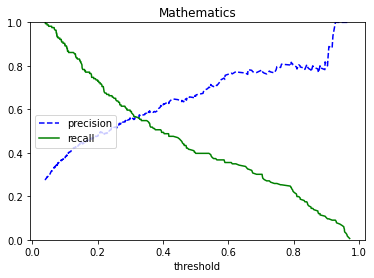

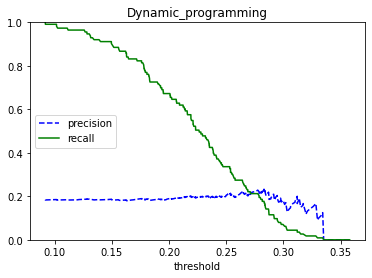

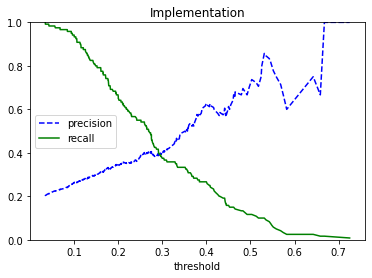

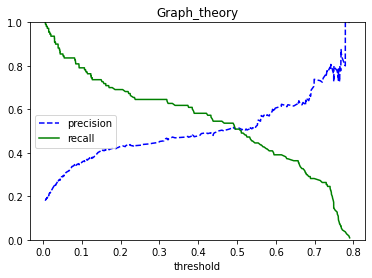

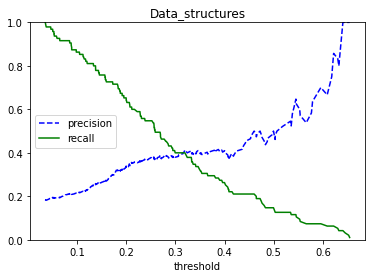

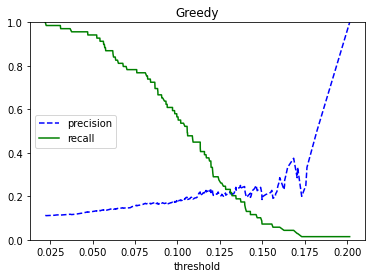

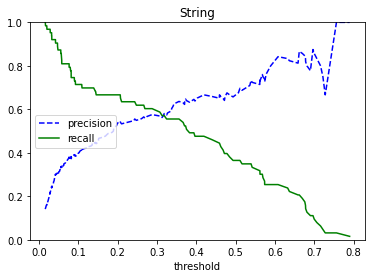

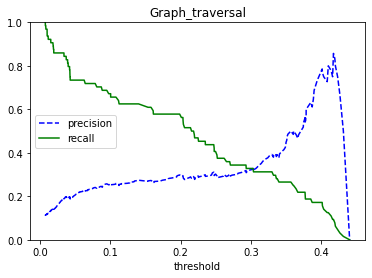

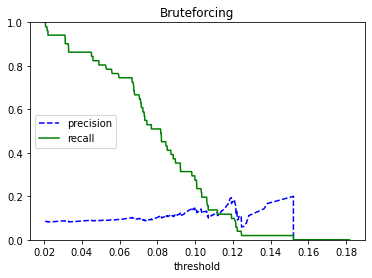

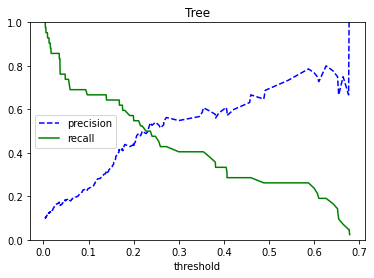

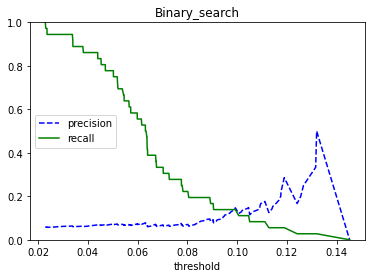

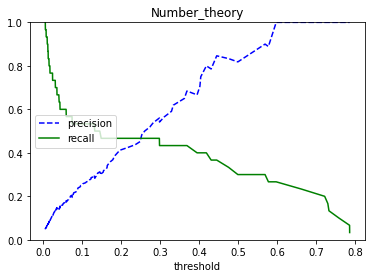

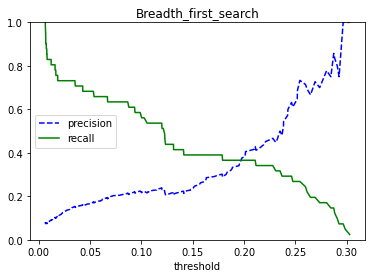

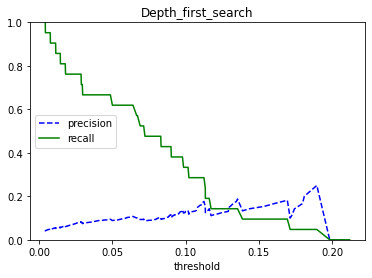

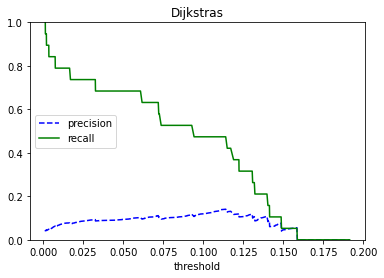

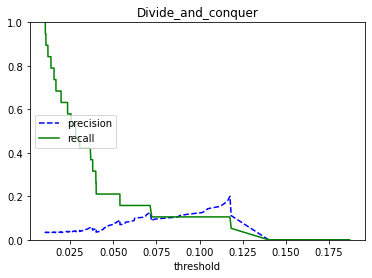

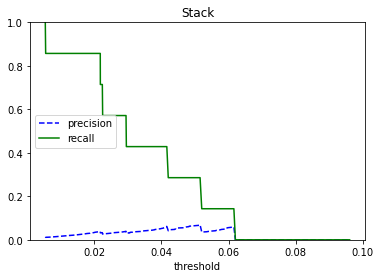

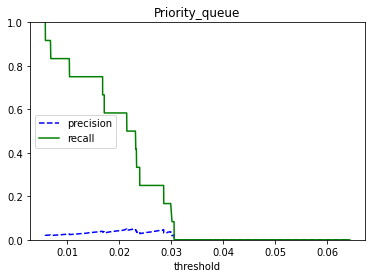

In [ ]:
from sklearn.metrics import precision_recall_curve

for i in range(18) :
  y_scores = pred_list[:,i]
  y_true = test_label[:,i]
  precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
  plot_precision_recall_vs_threshold(precision, recall, thresholds, len(thresholds))
  plt.title(target_name[i])
  plt.show()